In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

data = pd.read_csv("..\données\drought.csv")
data = data.drop(columns=['0','-9'])
data['DATE'] = pd.to_datetime(data['DATE'],format='d_%Y%m%d')
data['state'] =pd.Categorical(data['state'])
data['DSCI'] = data.D0 + data.D1 + data.D2 + data.D3 + data.D4

# Pour simplifier, nous étudions des séries temporelles univariées
data = data.drop(columns=['D0','D1','D2','D3','D4','W0','W1','W2','W3','W4'])
data

,DATE,state,DSCI
0,1895-01-01,alabama,0.0
1,1895-02-01,alabama,0.0
2,1895-03-01,alabama,0.0
3,1895-04-01,alabama,0.0
4,1895-05-01,alabama,0.0
...,...,...,...
73339,2021-12-01,wyoming,108.7
73340,2022-01-01,wyoming,85.7
73341,2022-02-01,wyoming,86.1
73342,2022-03-01,wyoming,50.0


In [30]:
# Nous nous concentrons d'abord sur les données de l'état de l'Alabama
X = data[data.state=='california'].sort_values('DATE')
X = X.drop(columns=['state']).sort_values('DATE').set_index('DATE')
X = X.reset_index()
X["DATE"] = X["DATE"].astype(str)
X["year"] = X["DATE"].str[0:4].astype(int)
X["month"] = X["DATE"].str[5:7].astype(int)
X["day"] = X["DATE"].str[8:10].astype(int)
X["1mago"] = X["DSCI"].shift(1)
X["2mago"] = X["DSCI"].shift(2)
X["3mago"] = X["DSCI"].shift(3)
X["1yago"] = X["DSCI"].shift(12)
X["2yago"] = X["DSCI"].shift(24)
X["3yago"] = X["DSCI"].shift(36)
X = X.dropna()

y = X.DSCI
X = X.drop(columns=["DATE","DSCI"])
X

,year,month,day,1mago,2mago,3mago,1yago,2yago,3yago
36,1898,1,1,111.5,11.1,0.2,0.0,35.2,0.0
37,1898,2,1,132.3,111.5,11.1,0.0,76.7,0.0
38,1898,3,1,131.2,132.3,111.5,0.0,39.3,0.0
39,1898,4,1,205.7,131.2,132.3,0.0,32.9,0.0
40,1898,5,1,231.7,205.7,131.2,0.0,29.6,0.0
...,...,...,...,...,...,...,...,...,...
1523,2021,12,1,156.3,165.6,242.5,230.0,8.3,57.1
1524,2022,1,1,14.5,156.3,165.6,251.3,18.9,21.4
1525,2022,2,1,43.4,14.5,156.3,347.4,191.1,1.2
1526,2022,3,1,104.0,43.4,14.5,372.3,158.6,1.8


In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
res = xgb_model.predict(X_test)

5165.925380710435

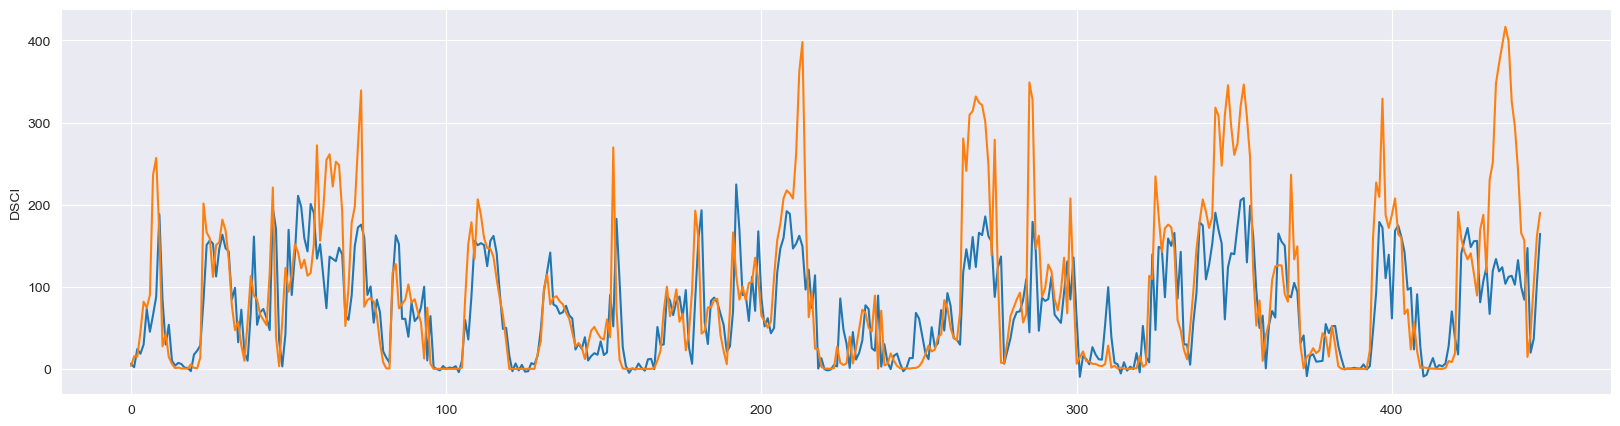

In [35]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
y_test = y_test.reset_index(drop=True)
plt.figure(figsize=(20,5))
ax11=sns.lineplot(res)
sns.lineplot(y_test,ax=ax11)
mean_squared_error(res,y_test)

In [15]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(1,20,1)}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(),
                        param_grid = param_test1)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 9}, 0.6028927468158366)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

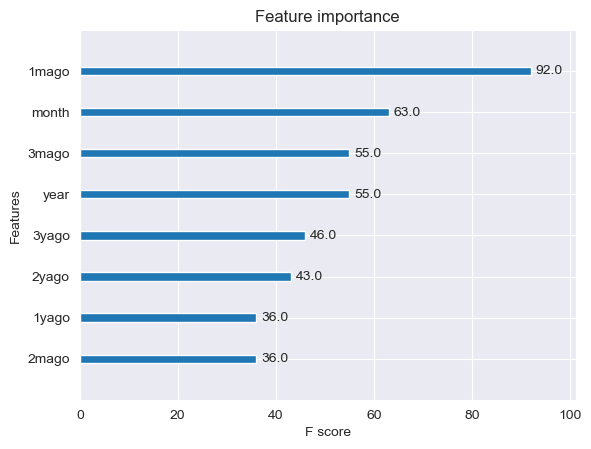

In [33]:
from xgboost import plot_importance
plot_importance(xgb_model)